_version log: using cross-collation to find the displacements for the angle (insted of using the maxmimums)_

In [150]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import pandas as pd
import os
import re
from scipy import interpolate, signal
from scipy.optimize import curve_fit
plt.rcParams.update({'font.size':14})

pixel_pitch = 9.9 #um
c = 299_792_458
source = "ir"
run = "11"

In [151]:
#################FUNCTIONS##################

def import_standard_tif(colour, number):
    im = Image.open('data\\'+colour+'_fringes'+number+'.tif')
    fringes = np.array(im, dtype= np.float32)
    im = Image.open('data\\'+colour+'_BA'+number+'.tif')
    beamA = np.array(im, dtype= np.float32)
    im = Image.open('data\\'+colour+'_BB'+number+'.tif')
    beamB = np.array(im, dtype= np.float32)
    im = Image.open('data\\'+colour+'_bg'+number+'.tif')
    background = np.array(im, dtype= np.float32)
    return fringes, beamA, beamB, background

def find_angle_files(colour, number):
    file_names = os.listdir("data\\")
    new_file_names=[]
    new_file_numbers=[]
    for file_name in file_names:
        check = re.findall(colour+'_fringes'+number+'_[0-9]+.tif' , file_name)
        if len(check) != 0:
            new_file_names = new_file_names + [file_name]

            file_number = re.findall('[0-9]+' , file_name)
            new_file_numbers = new_file_numbers + [int(file_number[-1]) -1] #the number that we are looking for is always the last number in the file name
    df = pd.DataFrame(np.transpose([new_file_names, new_file_numbers]), columns= ["file names", "file numbers"])
    df["file numbers"] = [int(number) for number in df["file numbers"]] #pandas forgot that numbers are intergers
    df = df.sort_values("file numbers", ignore_index= True) #I still don't know how to sort values using a key with numpy
    return df["file names"], df["file numbers"]

def combine_angle_arrays(file_names):
    im = Image.open('data\\'+file_names[0]) #for the first interferogram
    angles = np.array(im, dtype= np.float32)
    for file_name in file_names[1:]: #for every other interferogram
        im = Image.open('data\\'+file_name)
        Array = np.array(im, dtype= np.float32)
        angles = np.dstack([angles,Array])
    return angles

def process_fringes(fringes, beamA, beamB, background):
    try:
        nofringes = np.dstack([beamA +beamB -background] *fringes.shape[2]) #This will throw an error if fringes is 2d
    except IndexError:
        nofringes = beamA +beamB -background #ignore the error
    if False: #toggle which meathod you want to use. IDK which one is better.
        beamPost = fringes - nofringes #take away background. This meathod exaggerates the bandwidth.
    else:
        beamPost = fringes / nofringes #normalise using background. This meathod suffers with div0 errors and exaggerates the noise.
        beamPost = np.nan_to_num(beamPost, #This is unphysical but so is infinate intensity.
                                posinf= np.nanmax(beamPost[np.isfinite(beamPost)]), #occors for x/0
                                neginf= np.nanmin(beamPost[np.isfinite(beamPost)]), #occors for -x/0. this should be impossible
                                nan= 0) #occors for 0/0
        beamPost -= np.mean(beamPost)
    return beamPost, nofringes

def apply_cross_corrlations(angle_averages):
        cross_corr = signal.correlate(average_signal, angle_averages[:,0], mode='same') #use average_signal as a referance to find the displacements.
        lags = signal.correlation_lags(len(average_signal), len(angle_averages[:,0]), mode="same")
        displacements = lags[np.argmax(cross_corr)] #*pixel_pitch #convert from indexes to um.

        for n in np.arange(1,angle_averages.shape[1]): #for every other interferogram
                cross_corr = signal.correlate(angle_averages[:,n], average_signal, mode='same') #use average_signal as a referance to find the displacements.
                lags = np.arange(0, len(average_signal), 1)
                displacement = lags[np.argmax(cross_corr)] #*pixel_pitch #convert from indexes to um.
                displacements = np.hstack([displacements,displacement])

        return displacements

def line(x,m,k):
    return m*x+k

def Coeffients2Amplitudes(FT, freqs):
        samples = len(FT)
        num_of_freqs = len(FT)//2 +1
        amplitude = np.zeros(num_of_freqs)
        amplitude[0] = np.abs(FT[0])
        if (samples//2 == samples/2): #if even
                amplitude[num_of_freqs-1] = np.abs(FT[num_of_freqs-1])
                amplitude[1:-1] = (np.abs( FT[1:num_of_freqs-1] ) +
                                np.abs( FT[:num_of_freqs-1:-1] ))

                wavelengths = 1/freqs[:num_of_freqs +1]
                freqs = freqs[:num_of_freqs +1]
        else: #if odd
                amplitude[1:] = (np.abs( FT[1:num_of_freqs] ) +
                                np.abs( FT[:num_of_freqs-1:-1] ))
                wavelengths = 1/freqs[:num_of_freqs]
                freqs = freqs[:num_of_freqs]
        return amplitude, wavelengths, freqs

def import_csv(file_name, start_row):
    File = open('data\\'+file_name, 'rt')
    array = np.loadtxt(File, skiprows=start_row, delimiter = ",")
    File.close()
    return array

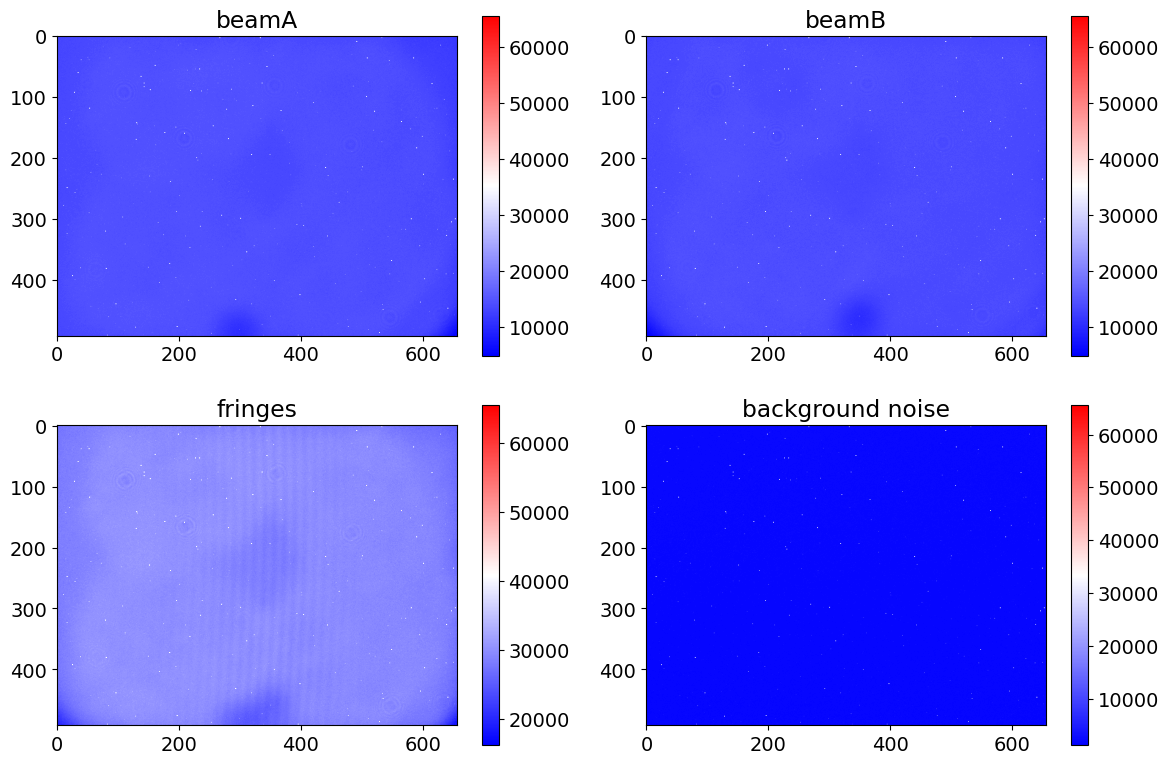

In [152]:
fringes, beamA, beamB, background = import_standard_tif(source, run)

plt.figure(figsize= (12,8))

plt.subplot(2,2,1)
im=plt.imshow(beamA, cmap='bwr')
plt.colorbar(im)
plt.title("beamA")

plt.subplot(2,2,2)
im=plt.imshow(beamB, cmap='bwr')
plt.colorbar(im)
plt.title("beamB")

plt.subplot(2,2,3)
im=plt.imshow(fringes, cmap='bwr')
plt.colorbar(im)
plt.title("fringes")

plt.subplot(2,2,4)
im=plt.imshow(background, cmap='bwr')
plt.colorbar(im)
plt.title("background noise")

plt.tight_layout()
plt.show()

In [153]:
file_names, file_numbers = find_angle_files(source, run)
angles = combine_angle_arrays(file_names)
angles, _ = process_fringes(angles, beamA, beamB, background)
beamPost, nofringes = process_fringes(fringes, beamA, beamB, background)

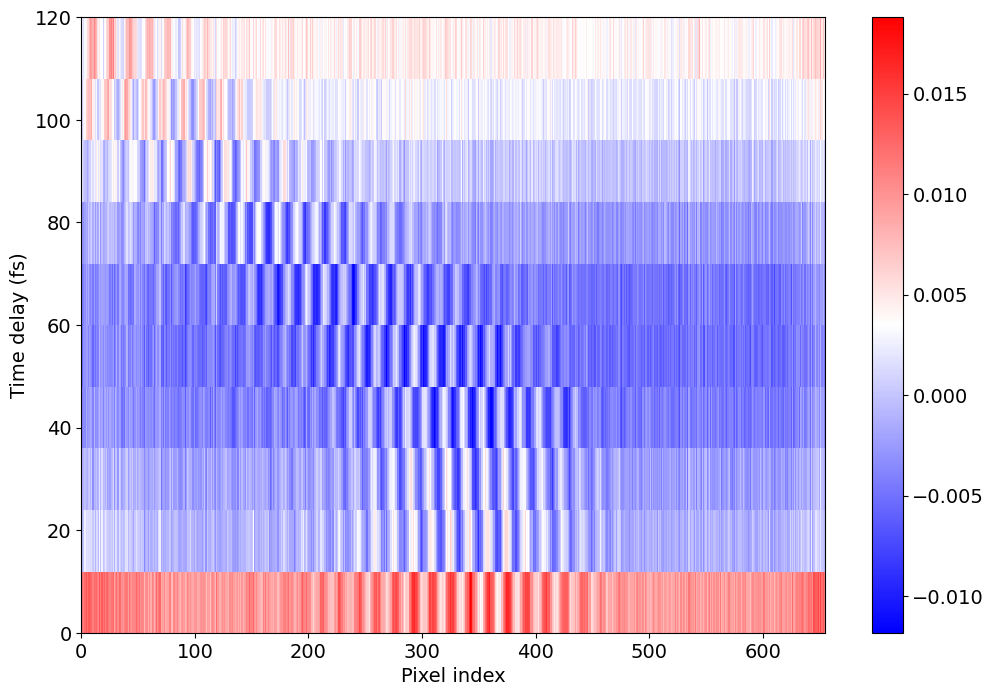

In [154]:
ROI = [[0,491],[0,655]] #region of interest in rows, columns. [[0,491],[0,655]]
delay_line_delta = 2 #um. Distance traveled by delay line between each reading
angle_averages = np.mean(angles[ROI[0][0]:ROI[0][1], ROI[1][0]:ROI[1][1]], axis = 0)
average_signal = np.mean(beamPost[ROI[0][0]:ROI[0][1], ROI[1][0]:ROI[1][1]], axis = 0)

delay_line_travel = np.arange(angle_averages.shape[1]) *delay_line_delta
time_delay = delay_line_travel *2 /c
time_delay *= 1e9 #convert from us to fs

plt.figure(figsize = (12,8))

ax = plt.subplot(1,1,1)
im=plt.imshow(np.transpose(angle_averages), 
            cmap='bwr', 
            aspect = "auto", 
            interpolation = "none", #"none" and "nearest" are the only physical ones
            origin = "lower", 
            extent=[0,angle_averages.shape[0],0,time_delay[-1]])
plt.colorbar(im)
plt.xlabel("Pixel index")
plt.ylabel("Time delay (fs)")

plt.show()

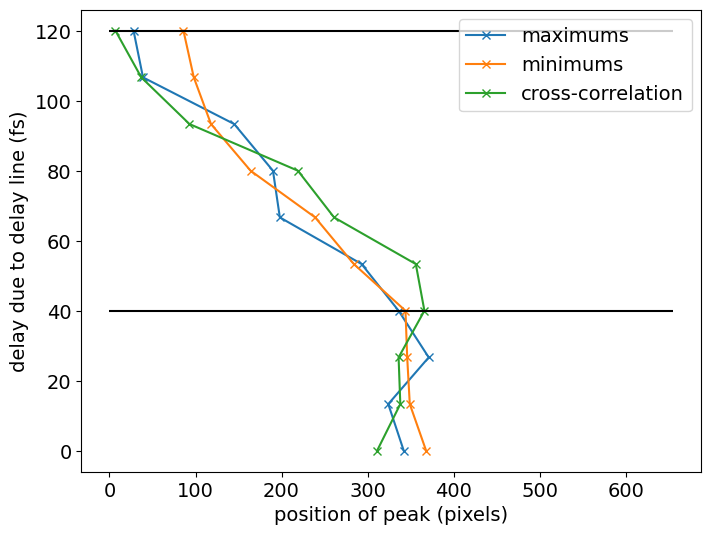

In [155]:
delay_line_bounds = [3,-1] #As the fringes move outside of the ROI, the peak position becomes inaccurate.

angle_maximums = np.argmax(angle_averages, axis = 0)
angle_minimums = np.argmin(angle_averages, axis = 0)
displacements = apply_cross_corrlations(angle_averages)

plt.figure(figsize = (8,6))

plt.plot(angle_maximums,
        time_delay,
        label = "maximums",
        marker = "x")
plt.plot(angle_minimums,
        time_delay,
        label = "minimums",
        marker = "x")
plt.plot(displacements,
        time_delay,
        label = "cross-correlation",
        marker = "x")

plt.hlines([time_delay[delay_line_bounds[0]],time_delay[delay_line_bounds[1]]], ROI[1][0], ROI[1][1], color = "k")
plt.ylabel('delay due to delay line (fs)')
plt.xlabel('position of peak (pixels)')
plt.legend()

plt.show()


In [156]:
popt, pcov = curve_fit(line, displacements[delay_line_bounds[0]:delay_line_bounds[1]], time_delay[delay_line_bounds[0]:delay_line_bounds[1]] )
m = popt[0]
k = popt[1]
err_m = np.sqrt(pcov[0][0]) /np.abs(m) #make into percentage error
err_k = np.sqrt(pcov[1][1]) /k

print("gradient = {0:.2e} +/- {1:.1e} ".format(m, err_m*m) + "fs/pixel")

m /= 1e9 *pixel_pitch #convert the gradient from fs/pixel to um/us (= m/s)
theta = np.arcsin(c *np.abs(m) /2 ) 
theta *= 180/np.pi #convert from radians to degrees
err_theta = theta *err_m #relies on the small angle appoximation. This is an underestimate.
print("angle between beams = {0:.3f} +/- {1:.3f}° or {2:.1f} +/- {3:.1f} arcminutes".format(2*theta, 2*err_theta, 60*2*theta, 60*2*err_theta))

gradient = -1.81e-01 +/- -1.8e-02 fs/pixel
angle between beams = 0.315 +/- 0.031° or 18.9 +/- 1.9 arcminutes


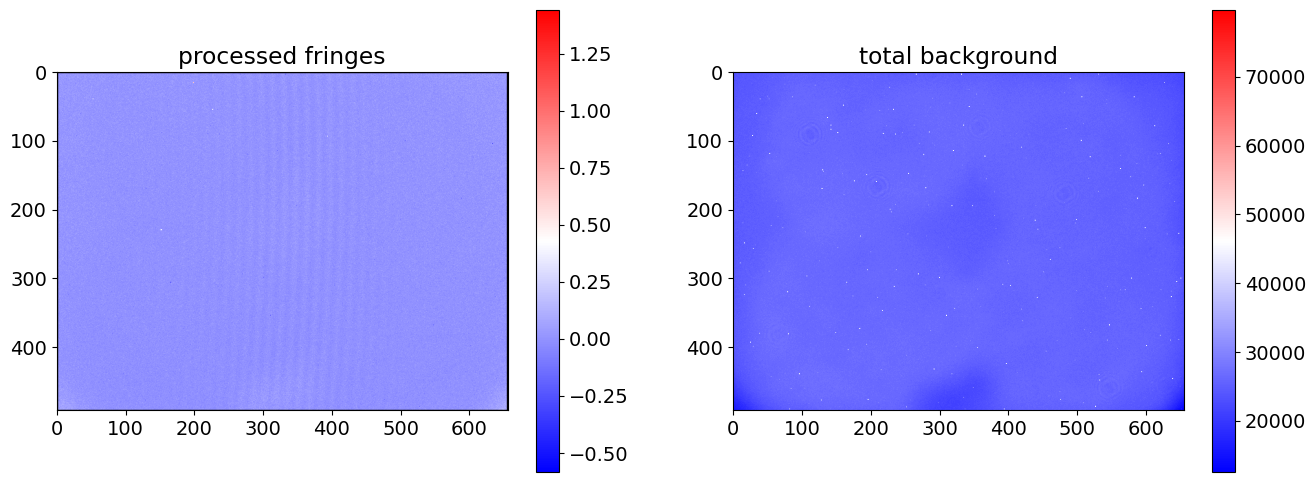

In [157]:
plt.figure(figsize = (16,6))

ax = plt.subplot(1,2,1)
im=plt.imshow(beamPost, cmap='bwr')
plt.colorbar(im)
plt.title("processed fringes")

# Create a Rectangle patch
rect = patches.Rectangle((ROI[1][0], ROI[0][0]), ROI[1][1]-ROI[1][0], ROI[0][1]-ROI[0][0], linewidth=1, edgecolor='k', facecolor='none')
ax.add_patch(rect)

plt.subplot(1,2,2)
im=plt.imshow(nofringes, cmap='bwr')
plt.colorbar(im)
plt.title("total background")

plt.show()

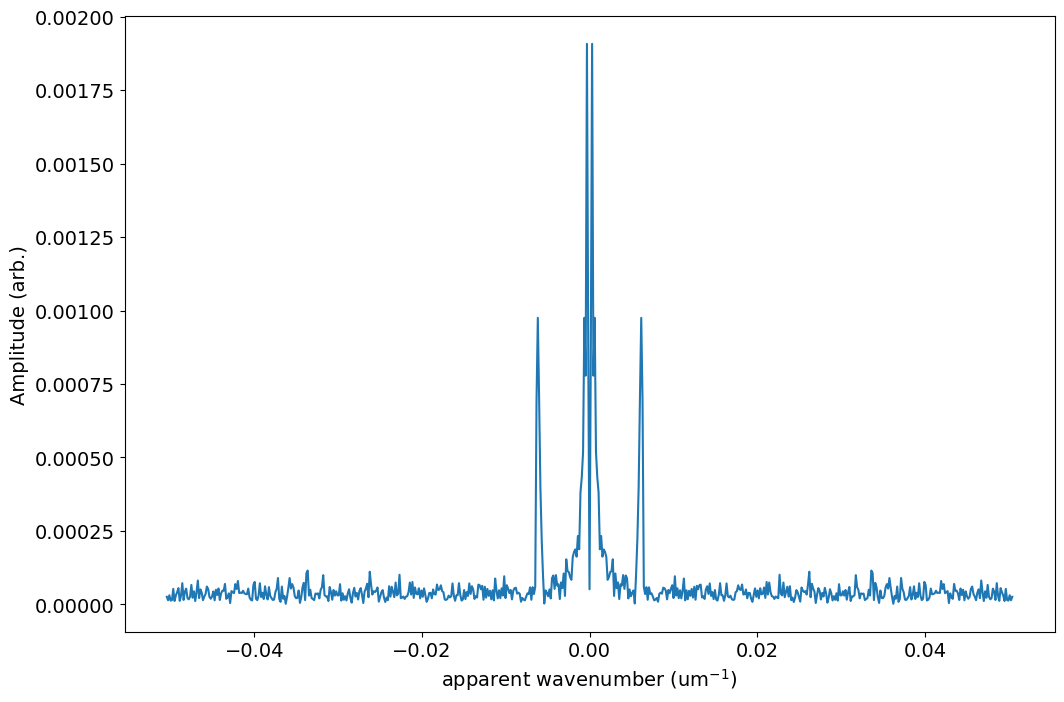

In [158]:
FT = np.fft.fft(average_signal, norm = "forward")

num_of_freqs = len(FT)//2 +1
samples = len(FT)
freqs = np.fft.fftfreq(len(FT), pixel_pitch)

plt.figure(figsize = (12,8))
plt.subplot(1, 1, 1)

plt.plot(np.fft.fftshift(freqs), #plt works best when the data set is in order
        np.fft.fftshift(abs(FT)))

plt.xlabel('apparent wavenumber (um$^{-1}$)')
plt.ylabel('Amplitude (arb.)')

plt.show()

C:\Users\syf83691\AppData\Local\Temp\ipykernel_19504\513791858.py:86: RuntimeWarning: divide by zero encountered in divide
  wavelengths = 1/freqs[:num_of_freqs]


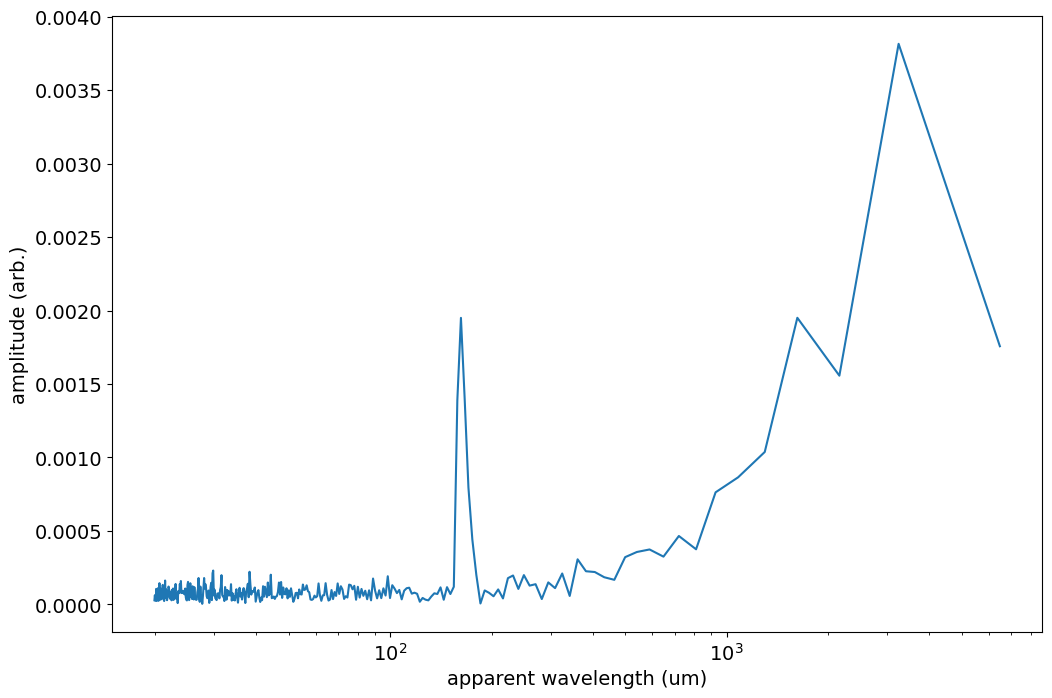

In [159]:
amplitude = np.zeros(num_of_freqs)
amplitude[0] = np.abs(FT[0])
amplitude, wavelengths, freqs = Coeffients2Amplitudes(FT, freqs)

plt.figure(figsize = (12,8))
plt.subplot(1, 1, 1)

plt.plot(wavelengths[:-1], #excule the infinate wavelength
        amplitude[:-1])
plt.xlabel('apparent wavelength (um)')
plt.ylabel('amplitude (arb.)')
plt.xscale("log")
plt.show()

In [160]:
################COMPENSATE FOR ANGLE#################
theta *= np.pi/180 #convert from degrees to radians
corrected_wavelengths = wavelengths *2*np.sin(theta) #we found theta earlier

###################CREATING AN EXPECTED SPECTRUM USING MANUFACURER DATA################## #I made a mess here. Pls clean up.

source = import_csv("SLS201L_spectrum.csv", 1)
source[:,1] = source[:,1] / np.max(source[:,1]) #normalise
source_function = interpolate.interp1d(source[:,0], source[:,1], fill_value= 0, bounds_error= False) #0 intensity seems like good assumtion here. Also try fill_value= np.nan

camera = import_csv("mantra_spectrum.csv", 0)
camera[:,1] = camera[:,1] / np.max(camera[:,1]) #normalise
camera_function = interpolate.interp1d(camera[:,0], camera[:,1], fill_value= 0, bounds_error= False) #0 intensity is a good assumtion for longer wavelengths

mirror = import_csv("unprotected_gold_mirror_spectrum.csv", 1)
mirror[:,0] *= 1e3 #convert to nm
mirror[:,1] = mirror[:,1] / np.max(mirror[:,1]) #normalise
mirror_function = interpolate.interp1d(mirror[:,0], mirror[:,1], fill_value= 0, bounds_error= False) #an extrapolation seems the most appropitate here

def manufacturers_function(x):
    return mirror_function(x) *source_function(x) *camera_function(x)
manufacturers = manufacturers_function(corrected_wavelengths[:-1] *1e3)

amplitude2 = amplitude[:-1] /np.nanmax(amplitude[:-1]) #normalise
percentagediff = (manufacturers_function(corrected_wavelengths[:-1] *1e3) - amplitude2) /amplitude2
amplitude2 *= np.nanmin(percentagediff[percentagediff != -1]) +1 #re-scale to fit

normalised_amplitude = amplitude2 / camera_function(corrected_wavelengths[:-1] *1e3) #factor in the camera sensitivity

C:\Users\syf83691\AppData\Local\Temp\ipykernel_19504\4184420031.py:28: RuntimeWarning: divide by zero encountered in divide
  normalised_amplitude = amplitude2 / camera_function(corrected_wavelengths[:-1] *1e3) #factor in the camera sensitivity


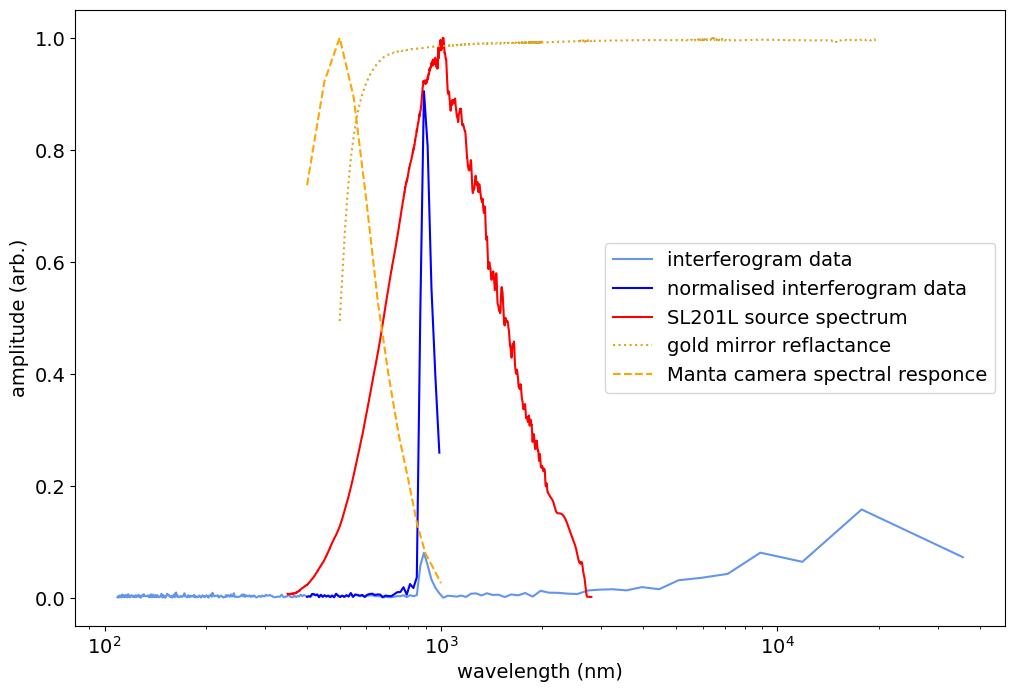

In [161]:
plt.figure(figsize = (12,8))
plt.subplot(1, 1, 1)

plt.plot(corrected_wavelengths[:-1] *1e3, #excule the infinate wavelength and convert to nm
        amplitude2, #rescale to fit
        label = "interferogram data",
        color = "cornflowerblue")
plt.plot(corrected_wavelengths[:-1] *1e3, #excule the infinate wavelength and convert to nm
        normalised_amplitude,
        label = "normalised interferogram data",
        color = "blue")
plt.plot(source[:,0],
        source[:,1],
        label = "SL201L source spectrum",
        color = "red")
plt.plot(mirror[:,0],
        mirror[:,1],
        label = "gold mirror reflactance",
        color = "goldenrod",
        linestyle = ":")
plt.plot(camera[:,0],
        camera[:,1],
        label = "Manta camera spectral responce",
        color = "orange",
        linestyle = "--")
plt.xlabel('wavelength (nm)')
plt.ylabel('amplitude (arb.)')
plt.xscale("log") 
plt.legend()
plt.show()

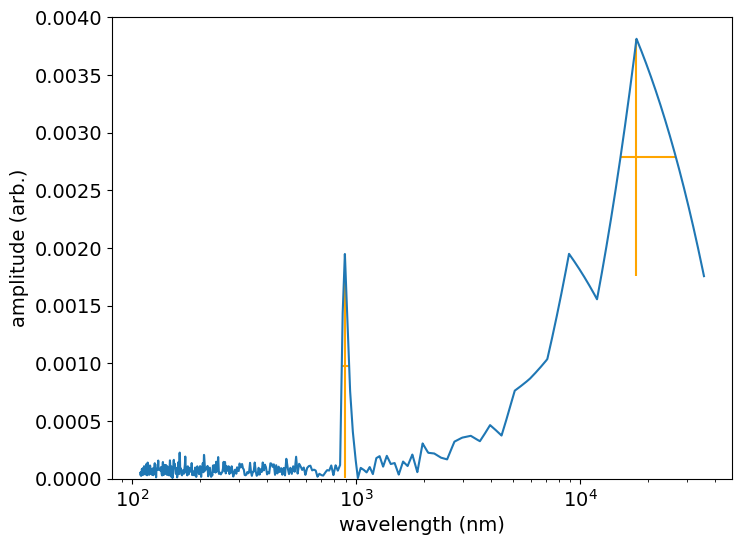

[  890.25534625 17804.31851598]
[  176.95582943 11715.24327845]


In [162]:
################FINDING PEAKS AND FWHM#####################

n = 100_000 #how many liniarlly spaced points to plot. It has to be liniar in order to be able to convert from indexes to um
relative_prominence = 5e-1 #this should be at least 1 / the S:N ratio.

spectrum_function = interpolate.interp1d(corrected_wavelengths[1:], amplitude[1:])
x = np.linspace(corrected_wavelengths[-1], corrected_wavelengths[1], n)
y = spectrum_function(x)

peaks, peak_properties = signal.find_peaks(y, prominence = relative_prominence*y.max()) #prominence = the smallest peak that can be considered a signal rather than noise. It would be nice to calculate this.
FWHM = signal.peak_widths(y, peaks, rel_height=0.5) #gives the FWHM in terms of indexes
FWHM = np.vstack(FWHM)

peaks = peaks * (corrected_wavelengths[1] - corrected_wavelengths[-1]) /n + corrected_wavelengths[-1] #convert to um
FWHM[np.arange(len(FWHM))!=1] = FWHM[np.arange(len(FWHM))!=1] * (corrected_wavelengths[1] - corrected_wavelengths[-1]) /n + corrected_wavelengths[-1] #convert to um.
FWHM[np.arange(len(FWHM))!=1] = FWHM[np.arange(len(FWHM))!=1]*1e3 #convert to nm. FWHM[np.arange(len(FWHM))!=1] will exclude index 1 (height of FWHM)

plt.figure(figsize = (8,6))
plt.subplot(1, 1, 1)

plt.xlabel('wavelength (nm)')
plt.ylabel('amplitude (arb.)')
#plt.xscale("log")
plt.hlines(*FWHM[1:,:], color = "orange")
plt.vlines(x= peaks*1e3,
           ymin= spectrum_function(peaks) - peak_properties["prominences"],
           ymax= spectrum_function(peaks), 
           color= "orange")
plt.plot(x *1e3,
        y)

#plt.xlim(3e2, 8e2)
plt.xscale("log")
plt.ylim(0)

plt.show()

print(peaks*1e3) # in nm
print(FWHM[0])